# Imports

In [145]:
# Change directory so imports work
import os
import sys
from pathlib import Path

repo_dir = Path("./").absolute()
assert repo_dir.name == "hypedsearch"
assert "src" in [d.name for d in repo_dir.iterdir() if d.is_dir()]
sys.path.append(str(repo_dir))

In [146]:
import logging
from src.utils import setup_logger, load_json
from src.crux import Crux
from src.mass_spectra import Mzml, Spectrum
from src.comet_utils import CometPSM
from src.kmer_database import create_kmer_database, KmerDatabase
from src.peptides_and_ions import Fasta
from src.hybrids_via_clusters import form_spectrum_hybrids_via_clustering
from src.hypedsearch import create_and_score_hybrids_for_spectrum, HypedsearchConfig

# Setup logger
root = logging.getLogger()
for handler in root.handlers[:]:  # copy the list since we modify it
    root.removeHandler(handler)
logger = setup_logger()

TUTORIAL_DIR = Path("tmp/tutorial")

# Full pipeline

In [ ]:
config = HypedsearchConfig(
    name="full-pipeline",
    mzml_to_scans={
        "data/spectra/mouse_samples/BMEM_AspN_Fxn4.mzML": [0], # [0] means all scans, [1,2,3] would mean only scans 1, 2, and 3
        "data/spectra/mouse_samples/BMEM_AspN_Fxn9.mzML": [0],
    },
    out_dir=TUTORIAL_DIR,
    fasta="fastas/SwissProt.TAW_mouse_w_NOD_IAPP.fasta",
)
cmd, _ = config.native_comet_snakemake_config_and_cmd()
# Uncomment the following line if you want to run Comet sequentially on the MZMLs and not via Snakemake
# config.native_comet_run()

2025-08-28 16:39:22,417 - venv - INFO - Updating scans for data/spectra/mouse_samples/BMEM_AspN_Fxn4.mzML from [0] to all of its scans...
2025-08-28 16:39:26,012 - venv - INFO - Updating scans for data/spectra/mouse_samples/BMEM_AspN_Fxn9.mzML from [0] to all of its scans...
2025-08-28 16:39:27,085 - venv - INFO - Saved native Comet run snakemake config to tmp/tutorial/full-pipeline/native_run/native_run.smk.config.json. To run snakemake, use this command:
snakemake -s /Users/erjo3868/repos/hypedsearch/hypedsearch/snakefiles/run_comet.smk --configfile tmp/tutorial/full-pipeline/native_run/native_run.smk.config.json ...


In [149]:
config.native_assign_confidence()
config.create_kmer_database_from_top_n_proteins(
    top_n_proteins=10, q_value_threshold=0.5
)
config.create_hybrid_run_snakemake_config_and_cmd()

2025-08-28 16:42:45,684 - venv - INFO - Running 'crux assign-confidence'...
2025-08-28 16:42:45,685 - venv - INFO - Running command:
/Users/erjo3868/repos/hypedsearch/hypedsearch/comet/crux-4.3.Darwin.x86_64/bin/crux assign-confidence --overwrite T --output-dir /var/folders/wt/l509j2v13614w84pwcgyhw9w0000gp/T/tmpdufpumlp --list-of-files T tmp/tutorial/full-pipeline/native_run/BMEM_AspN_Fxn4.comet.0-0.target.txt tmp/tutorial/full-pipeline/native_run/BMEM_AspN_Fxn9.comet.0-0.target.txt
2025-08-28 16:42:46,490 - venv - INFO - Finished running 'crux assign-confidence'
2025-08-28 16:42:47,469 - venv - INFO - Top 10 proteins:
['sp|P01325|INS1_MOUSE', 'sp|P01326|INS2_MOUSE', 'sp|P16014|SCG1_MOUSE', 'sp|P99027|RLA2_MOUSE', 'sp|P26339|CMGA_MOUSE', 'sp|P01942|HBA_MOUSE', 'sp|Q03517|SCG2_MOUSE', 'sp|P35564|CALX_MOUSE', 'sp|P47867|SCG3_MOUSE', 'sp|Q9QXV0|PCSK1_MOUSE']
2025-08-28 16:42:47,642 - root - INFO - load took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 16:42:47,642 - src.kmer_database - INFO 

2025-08-28 16:22:30,852 - venv - INFO - Running 'crux assign-confidence'...
2025-08-28 16:22:30,853 - venv - INFO - Running command:
/Users/erjo3868/repos/hypedsearch/hypedsearch/comet/crux-4.3.Darwin.x86_64/bin/crux assign-confidence --overwrite T --output-dir /var/folders/wt/l509j2v13614w84pwcgyhw9w0000gp/T/tmpsm6qfvyy --list-of-files T tmp/tutorial/full-pipeline/hybrid_run/10_mouse_spectra.comet.target.txt tmp/tutorial/full-pipeline/hybrid_run/100_mouse_spectra.comet.target.txt
2025-08-28 16:22:31,006 - venv - INFO - Finished running 'crux assign-confidence'


[]

2025-08-28 16:22:31,023 - venv - INFO - Saved hybrids to tmp/tutorial/full-pipeline/highConfidence_q=0.7_minSideLen=2_hybrids.csv


""


/Users/erjo3868/repos/hypedsearch/hypedsearch/src/plot_utils.py:117: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


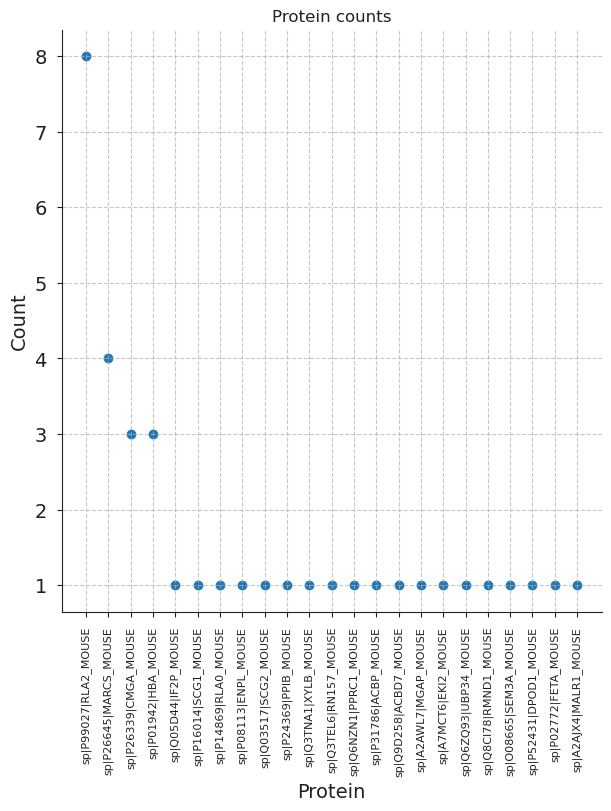

In [ ]:
config.combine_scan_results_and_run_assign_confidence()

# Analyze results
q_value_threshold = 0.01
min_hybrid_side_len = 6
config.high_confidence_psms(
    q_value_threshold=q_value_threshold, psm_type="hybrid"
).psms[:3]
config.save_hybrids(
    min_side_len=min_hybrid_side_len, 
    q_value_threshold=q_value_threshold, 
    out_path=config.name_dir / f"highConfidence_q={q_value_threshold}_minSideLen={min_hybrid_side_len}_hybrids.csv"
)
config.protein_count_plot(q_value_threshold=q_value_threshold)

The next step is to create the k-mer SQL database (kDB) which is just a database that holds the k-mers that you want to use to construct possible hybrids. 
Every hybrid peptide (A-B) that Hypedsearch returns will consist of two k-mers from kDB (both A and B are in kDB). 
Choosing which k-mers one wants in this database is often done in one of two ways.

The first way is simple: include all k-mers in a proteome/FASTA (for k between some $k_{min}$ and $k^{max}$). 
The first way's benefit is that kDB will contain all k-mers so all possible hybrid peptides will be considered.
The first way's drawback is primarily that including all k-mers often results in a database that's very large (i.e., eats up a lot of memory) and can take a relatively long time to create, query, and increases the number of potential hybrids exponentially. 

A second way to create kDB is to include only the k-mers from highly abundant proteins. 
If the number of highly abundant proteins is much smaller than the number of proteins in the proteome (which it usually is), than the result database will be much smaller and HypedSearch will run considerably faster.
And, because biochemically we expect hyrid peptides to primarily form between proteins (and peptides) in high abundance, the algorithm speed up at the cost of a complete set of k-mers may not result in much of a loss of detected hybrid peptides. 

# Individual components of the pipeline

## Run [`crux comet`](https://crux.ms/commands/comet.html) and [`crux assign-confidence`](https://crux.ms/commands/assign-confidence.html) (for q-value control)

The cell below shows how to run Comet via `crux` followed by `crux assign-confidence` which one can use for q-value control.

In [ ]:
mzml = Path("tests/data/spectra/100_mouse_spectra.mzML")
crux_comet_params = Path("comet/crux.comet.params")
fasta = Path("fastas/SwissProt.TAW_mouse_w_NOD_IAPP.fasta")
crux_path = Path("comet/crux-4.3.Darwin.x86_64/bin/crux")
out_dir = TUTORIAL_DIR / "run_comet_sequentially"
out_dir.mkdir(parents=True, exist_ok=True)


# Run Comet on MZML
crux = Crux(path=crux_path)
comet_outputs = crux.run_comet(
    mzml=mzml,
    fasta=fasta,
    crux_comet_params=crux_comet_params,
    decoy_search=2,
    out_dir=out_dir,
    file_root=Mzml.get_mzml_name(mzml=mzml),
)

# Assign confidence
assign_confidence_txt = out_dir / "assign-confidence.txt"
crux.run_assign_confidence(
    target_txts=[comet_outputs.target],
    out_path=assign_confidence_txt,
)

# Read in the PSMs in the assign-confidence txt
psms = CometPSM.from_txt(txt=assign_confidence_txt, as_df=True)
psms.head()

2025-08-28 15:20:16,387 - venv - INFO - Running Comet with command:
comet/crux-4.3.Darwin.x86_64/bin/crux comet --verbosity 60 --parameter-file comet/crux.comet.params --decoy_search 2 --fileroot '100_mouse_spectra' --scan_range '0 0' --output-dir /var/folders/wt/l509j2v13614w84pwcgyhw9w0000gp/T/tmptmlf887f  tests/data/spectra/100_mouse_spectra.mzML fastas/SwissProt.TAW_mouse_w_NOD_IAPP.fasta
2025-08-28 15:20:20,307 - venv - INFO - Moving /var/folders/wt/l509j2v13614w84pwcgyhw9w0000gp/T/tmptmlf887f/100_mouse_spectra.comet.target.txt to tmp/tutorial/run_comet/100_mouse_spectra.comet.target.txt
2025-08-28 15:20:20,309 - venv - INFO - Running 'crux assign-confidence'...
2025-08-28 15:20:20,310 - venv - INFO - Running command:
comet/crux-4.3.Darwin.x86_64/bin/crux assign-confidence --overwrite T --output-dir /var/folders/wt/l509j2v13614w84pwcgyhw9w0000gp/T/tmp5nt30uv2 --list-of-files T tmp/tutorial/run_comet/100_mouse_spectra.comet.target.txt
2025-08-28 15:20:20,460 - venv - INFO - Finishe

,file,scan,charge,retention time,spectrum precursor m/z,spectrum neutral mass,peptide mass,delta_cn,sp score,sp rank,xcorr,num,e-value,q_value,ions_matched,ions_total,total matches/spectrum,plain_peptide,unmodified sequence,protein,flanking aa,sample
0,tmp/tutorial/run_comet/100_mouse_spectra.comet...,92,3,-1.0,608.3145,1821.9218,1821.9221,0.6092,832,1,4.660,1,6.470000e-10,0.071429,41,80,83458,AAPGSAAPAAGSAPAAAEEKK,AAPGSAAPAAGSAPAAAEEKK,sp|P99027|RLA2_MOUSE,SD,100_mouse_spectra
1,tmp/tutorial/run_comet/100_mouse_spectra.comet...,97,3,-1.0,560.9576,1679.8510,1679.8480,0.6426,559,1,4.468,1,5.850000e-09,0.071429,33,72,80140,PGSAAPAAGSAPAAAEEKK,PGSAAPAAGSAPAAAEEKK,sp|P99027|RLA2_MOUSE,AD,100_mouse_spectra
2,tmp/tutorial/run_comet/100_mouse_spectra.comet...,65,3,-1.0,673.3152,2016.9237,2016.9236,0.6036,592,1,4.208,1,2.480000e-09,0.071429,21,72,46109,DAAAVKPTENNEEESASKQ,DAAAVKPTENNEEESASKQ,sp|Q05D44|IF2P_MOUSE,RD,100_mouse_spectra
3,tmp/tutorial/run_comet/100_mouse_spectra.comet...,50,3,-1.0,577.2803,1728.8190,1728.8168,0.5080,433,1,3.504,1,6.420000e-02,0.071429,23,68,60850,DKEEPASGSAATPAAAEK,DKEEPASGSAATPAAAEK,sp|P26645|MARCS_MOUSE,AD,100_mouse_spectra
4,tmp/tutorial/run_comet/100_mouse_spectra.comet...,40,3,-1.0,577.2803,1728.8190,1728.8168,0.4586,214,1,3.347,1,1.950000e-03,0.071429,17,68,60850,DKEEPASGSAATPAAAEK,DKEEPASGSAATPAAAEK,sp|P26645|MARCS_MOUSE,AD,100_mouse_spectra


Alternatively, especially if you want to run Comet in parallel using multiple cores, the next cell shows how to create a Snakemake config JSON file and print the Snakemake command you can use to run Snakemake:

In [104]:
from src.crux import CometConfig

mzml_to_scans = {
    Path("tests/data/spectra/10_mouse_spectra.mzML"): [0], # [0] means all scans, [1,2,3] would mean only scans 1, 2, and 3
    Path("tests/data/spectra/100_mouse_spectra.mzML"): [0],
}
crux_comet_params = Path("comet/crux.comet.params")
fasta = Path("fastas/SwissProt.TAW_mouse_w_NOD_IAPP.fasta")
crux_path = Path("comet/crux-4.3.Darwin.x86_64/bin/crux")
out_dir = TUTORIAL_DIR / "run_comet_via_snakemake"
out_dir.mkdir(parents=True, exist_ok=True)

config = CometConfig(
    mzml_to_scans=mzml_to_scans,
    crux_comet_params=crux_comet_params,
    fasta=fasta,
    crux_path=crux_path,
    out_dir=out_dir,
    decoy_search=2
)
config_path = out_dir / "run_comet.config.json"
config.save(path=config_path)
print(f"To run Comet via Snakemake, run the following command:\n{config.run_comet_snakemake_command(config_path=config_path)}")


To run Comet via Snakemake, run the following command:
snakemake -s /Users/erjo3868/repos/hypedsearch/hypedsearch/snakefiles/run_comet.smk --configfile tmp/tutorial/run_comet_via_snakemake/run_comet.config.json ...


## Create k-mer database

The cell below shows how to create the k-mer database that stores the k-mers from which hybrid peptides are formed.
To create a k-mer database, you need to provide a list of Peptide objects representing the amino acid sequences whose k-mers will be added to the database.
The end result will be a k-mer SQL database saved to a given path and a kmer-to-protein map saved as a JSON (or compressed pickled file (`.pklz`)) to a given path.

In [112]:
fasta = Path("fastas/SwissProt.TAW_mouse_w_NOD_IAPP.fasta")
proteins = Path("tests/data/mouse_data_top_10_proteins.txt")
out_dir = TUTORIAL_DIR / "create_kmer_db"
out_dir.mkdir(parents=True, exist_ok=True)
kmer_to_proteins_map = out_dir / "kmer_to_proteins_map.json"
db_path = out_dir / "kmers.db"

db = create_kmer_database(
    proteins=Fasta(path=fasta).get_proteins_by_name(protein_names=proteins),
    min_k=2,
    max_k=6,
    kmer_to_proteins_path=kmer_to_proteins_map,
    db_path=db_path,
)
assert db_path.exists()
assert kmer_to_proteins_map.exists()

2025-08-28 15:45:39,455 - root - INFO - load took 0.01 secs = 0.0 mins = 0.0 hrs
2025-08-28 15:45:39,455 - src.kmer_database - INFO - kmer-to-protein map already exists... Skipping creation
2025-08-28 15:45:39,455 - src.kmer_database - INFO - Database already exists... Skipping creation


## Form hybrid peptides for a spectrum

Given an MS2 spectrum, a k-mer database from which to form hybrid peptides, and some additional parameters that control which hybrid peptides we permit (i.e., `precursor_mz_ppm_tol`, `peak_to_ion_ppm_tol`, `min_cluster_len`, and `min_cluster_support`), the cell below shows how form the hybrid peptides that may explain the given spectrum. 

In [117]:
mzml = Path("tests/data/BMEM_AspN_Fxn4.mzML")
scan = 7
spectrum = Spectrum.get_spectrum(mzml=mzml, scan=scan)
kmer_db =  KmerDatabase(db_path=Path("tests/data/mouse_top_10_proteins.db"))
protein_name_to_seq_map = Fasta(
    path=Path("fastas/SwissProt.TAW_mouse_w_NOD_IAPP.fasta")
).protein_name_to_seq_map
kmer_to_proteins_map = load_json(Path("tests/data/kmer_to_proteins_map.json"))
precursor_mz_ppm_tol = 20
peak_to_ion_ppm_tol = 20
min_cluster_len = 5
min_cluster_support = 2

seq_to_hybrids = form_spectrum_hybrids_via_clustering(
    spectrum=spectrum,
    kmer_db=kmer_db,
    protein_name_to_seq_map=protein_name_to_seq_map,
    kmer_to_proteins_map=kmer_to_proteins_map,
    precursor_mz_ppm_tol=precursor_mz_ppm_tol,
    peak_to_ion_ppm_tol=peak_to_ion_ppm_tol,
    min_cluster_len=min_cluster_len,
    min_cluster_support=min_cluster_support,
)
seq_to_hybrids

2025-08-28 15:57:15,051 - root - INFO - get_peak_ion_matches_for_spectrum took 0.02 secs = 0.0 mins = 0.0 hrs
2025-08-28 15:57:15,070 - root - INFO - from_positioned_ions took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 15:57:15,071 - src.hybrids_via_clusters - INFO - Before filtering, there are 811 b-clusters and 684 y-clusters.
2025-08-28 15:57:15,071 - root - INFO - filter_clusters took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 15:57:15,071 - src.hybrids_via_clusters - INFO - After filtering, there are 167 b-clusters and 117 y-clusters.
2025-08-28 15:57:15,078 - root - INFO - insert_dataclasses took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 15:57:15,079 - root - INFO - add_index took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 15:57:15,091 - root - INFO - form_hybrids_from_left_and_right_seqs took 0.02 secs = 0.0 mins = 0.0 hrs
2025-08-28 15:57:15,092 - root - INFO - form_hybrids_from_clusters took 0.02 secs = 0.0 mins = 0.0 hrs
2025-08-28 15:57:15,092 - src.hybrids_via_clusters - INFO - Re

defaultdict(list,
            {'LWEPKPTQAFVGPG': [HybridPeptide(left_seq='LWEPKPTQAFV', right_seq='GPG', left_proteins={'sp|P01325|INS1_MOUSE'}, right_proteins={'sp|P01326|INS2_MOUSE'}, fasta_description='left-prots:sp|P01325|INS1_MOUSE;right-prots:sp|P01326|INS2_MOUSE', scan=7, sample='BMEM_AspN_Fxn4')],
             'LWEPKPTQAFVNP': [HybridPeptide(left_seq='LWEPKPTQAFV', right_seq='NP', left_proteins={'sp|P01325|INS1_MOUSE'}, right_proteins={'sp|P12968B|IAPP_MOUSE', 'sp|P12968|IAPP_MOUSE'}, fasta_description='left-prots:sp|P01325|INS1_MOUSE;right-prots:sp|P12968B|IAPP_MOUSE,sp|P12968|IAPP_MOUSE', scan=7, sample='BMEM_AspN_Fxn4')],
             'LWEPKPTQAFVPN': [HybridPeptide(left_seq='LWEPKPTQAFV', right_seq='PN', left_proteins={'sp|P01325|INS1_MOUSE'}, right_proteins={'sp|P12968B|IAPP_MOUSE', 'sp|Q03517|SCG2_MOUSE'}, fasta_description='left-prots:sp|P01325|INS1_MOUSE;right-prots:sp|P12968B|IAPP_MOUSE,sp|Q03517|SCG2_MOUSE', scan=7, sample='BMEM_AspN_Fxn4')],
             'TQWIPDVESRQ

## Form and score (using Comet (via `crux comet`)) hybrid peptides for a spectrum

The cell below shows how to create hybrid peptides and score those hybrids via Comet to get a set of PSMs for a given spectrum.

In [121]:
mzml = Path("tests/data/BMEM_AspN_Fxn4.mzML")
scan = 7
spectrum = Spectrum.get_spectrum(mzml=mzml, scan=scan)
kmer_db =  KmerDatabase(db_path=Path("tests/data/mouse_top_10_proteins.db"))
protein_name_to_seq_map = Fasta(
    path=Path("fastas/SwissProt.TAW_mouse_w_NOD_IAPP.fasta")
).protein_name_to_seq_map
kmer_to_proteins_map = load_json(Path("tests/data/kmer_to_proteins_map.json"))
precursor_mz_ppm_tol = 20
peak_to_ion_ppm_tol = 20
min_cluster_len = 5
min_cluster_support = 2
crux_comet_params = Path("comet/crux.comet.params")
fasta = Path("fastas/SwissProt.TAW_mouse_w_NOD_IAPP.fasta")
crux_path = Path("comet/crux-4.3.Darwin.x86_64/bin/crux")
out_dir = TUTORIAL_DIR / "create_and_score_hybrids"
out_dir.mkdir(parents=True, exist_ok=True)

outputs = create_and_score_hybrids_for_spectrum(
    spectrum=spectrum,
    kmer_db=kmer_db,
    protein_name_to_seq_map=protein_name_to_seq_map,
    kmer_to_proteins_map=kmer_to_proteins_map,
    precursor_mz_ppm_tol=precursor_mz_ppm_tol,
    peak_to_ion_ppm_tol=peak_to_ion_ppm_tol,
    min_cluster_len=min_cluster_len,
    min_cluster_support=min_cluster_support,
    crux_comet_params=crux_comet_params,
    fasta=fasta,
    crux_path=crux_path,
    out_dir=out_dir
)

# Load spectrum PSM
CometPSM.from_txt(txt=outputs.target, as_df=True)

2025-08-28 16:01:44,778 - venv - INFO - Forming hybrids...
2025-08-28 16:01:44,797 - root - INFO - get_peak_ion_matches_for_spectrum took 0.02 secs = 0.0 mins = 0.0 hrs
2025-08-28 16:01:44,817 - root - INFO - from_positioned_ions took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 16:01:44,818 - src.hybrids_via_clusters - INFO - Before filtering, there are 811 b-clusters and 684 y-clusters.
2025-08-28 16:01:44,818 - root - INFO - filter_clusters took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 16:01:44,818 - src.hybrids_via_clusters - INFO - After filtering, there are 167 b-clusters and 117 y-clusters.
2025-08-28 16:01:44,825 - root - INFO - insert_dataclasses took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 16:01:44,825 - root - INFO - add_index took 0.0 secs = 0.0 mins = 0.0 hrs
2025-08-28 16:01:44,837 - root - INFO - form_hybrids_from_left_and_right_seqs took 0.02 secs = 0.0 mins = 0.0 hrs
2025-08-28 16:01:44,838 - root - INFO - form_hybrids_from_clusters took 0.02 secs = 0.0 mins = 0.0 hrs
202

,scan,charge,spectrum precursor m/z,spectrum neutral mass,peptide mass,delta_cn,sp score,sp rank,xcorr,num,ions_matched,ions_total,total matches/spectrum,plain_peptide,modified sequence,modifications,protein,flanking aa,e-value,sample
0,7,3,509.598654,1525.774133,1525.773636,0.0914,260.0,1,2.407,1,16,64,74660,SAAPAAGSAPAALTEKN,-.SAAPAAGSAPAALTEKN.-,-,hybrid_SAAPAAGSAPAALTEKN,--,1.52,BMEM_AspN_Fxn4
1,7,3,509.598654,1525.774133,1525.773636,0.0311,229.0,2,2.187,2,15,64,74660,SAAPAAGSAPAAAEEKK,G.SAAPAAGSAPAAAEEKK.D,-,sp|P99027|RLA2_MOUSE,GD,3.22,BMEM_AspN_Fxn4
2,7,3,509.598654,1525.774133,1525.773636,0.0000,194.0,4,2.119,3,14,64,74660,ASAPAAGSAPAAAEEKK,-.ASAPAAGSAPAAAEEKK.-,-,hybrid_ASAPAAGSAPAAAEEKK,--,4.06,BMEM_AspN_Fxn4
3,7,3,509.598654,1525.774133,1525.773636,0.0038,194.0,4,2.119,4,14,64,74660,TGAPAAGSAPAAAEEKK,-.TGAPAAGSAPAAAEEKK.-,-,hybrid_TGAPAAGSAPAAAEEKK,--,4.06,BMEM_AspN_Fxn4
4,7,3,509.598654,1525.774133,1525.762402,0.0346,198.0,3,2.111,5,14,64,74660,SAAPAAGSAPPLVETST,-.SAAPAAGSAPPLVETST.-,-,hybrid_SAAPAAGSAPPLVETST,--,4.17,BMEM_AspN_Fxn4
